<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [2]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [9]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians': 7,
        'muslims': 8,
        'no religion': 9,
        'buddhists': 10,
        'hindus': 11,
        'jews': 12,
        'other religion': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'education man': 20,
        'education women': 21,
        'hdi': 22,
        'gii': 23,
        'avg marriage age women': 24,
        'avg marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortions': 29,
        'social media users': 30
    }
    countries = sorted(list(set([key[0] for key in data.keys()])))
    df = pd.DataFrame(index=countries, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for country in countries:
        key = (country, year)
        if key in data:
            features = data[key][1]
            target.append(data[key][0])
            for feature_name, feature_index in feature_map.items():
                if feature_index < len(features):
                  df.loc[country, feature_name] = features[feature_index]
                  if str(features[feature_index]) =='nan':
                    df.loc[country, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c
            return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return values[-1] # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [16]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(country)

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [17]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortions': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if country in df_features.index:
                df_features.loc[country, feature] = value


    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Z-scale 'physicians per capita' and 'health expenditure'
    scaler_physicians = StandardScaler()
    X_train['physicians per capita_scaled'] = scaler_physicians.fit_transform(X_train[['physicians per capita']])
    X_test['physicians per capita_scaled'] = scaler_physicians.transform(X_test[['physicians per capita']])

    scaler_health = StandardScaler()
    X_train['health expenditure_scaled'] = scaler_health.fit_transform(X_train[['health expenditure']])
    X_test['health expenditure_scaled'] = scaler_health.transform(X_test[['health expenditure']])

    # Create 'healthcare index score'
    X_train['healthcare index score'] = X_train['physicians per capita_scaled'] + X_train['health expenditure_scaled']
    X_test['healthcare index score'] = X_test['physicians per capita_scaled'] + X_test['health expenditure_scaled']

    # Remove original 'physicians per capita' and 'health expenditure' features
    X_train = X_train.drop(['physicians per capita', 'health expenditure', 'physicians per capita_scaled', 'health expenditure_scaled'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure', 'physicians per capita_scaled', 'health expenditure_scaled'], axis=1)
    return X_train, X_test, y_train, y_test

In [18]:

X_train, X_test, y_train, y_test = process_2023_data(init_process())

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high_education_female.xlsx to data/high_education_female.xlsx
Downloaded high_educati

In [20]:
print (X_train)

         urbanization avg birth age happiness female labor participation  \
Mali        44.585857        28.859     4.232                     41.852   
Georgia       60.1143        28.501     5.185                     55.004   
Albania     61.257164        29.132     5.304                  59.350071   
Benin         50.1711        29.079     4.377                     74.346   
Ethiopia    22.341082        29.079     3.861                     57.604   
...               ...           ...       ...                        ...   
Lesotho     36.038677         27.91     3.186                  43.358333   
Senegal     50.530487         29.92     4.969                     38.406   
Bolivia      71.37134        28.144     5.784                     72.587   
Niger       22.460955        29.085     4.556                     73.288   
Portugal     67.48844        31.727      6.03                     55.562   

          GNI PPP christians    muslims no religion buddhists    hindus  ...  \
Mali   

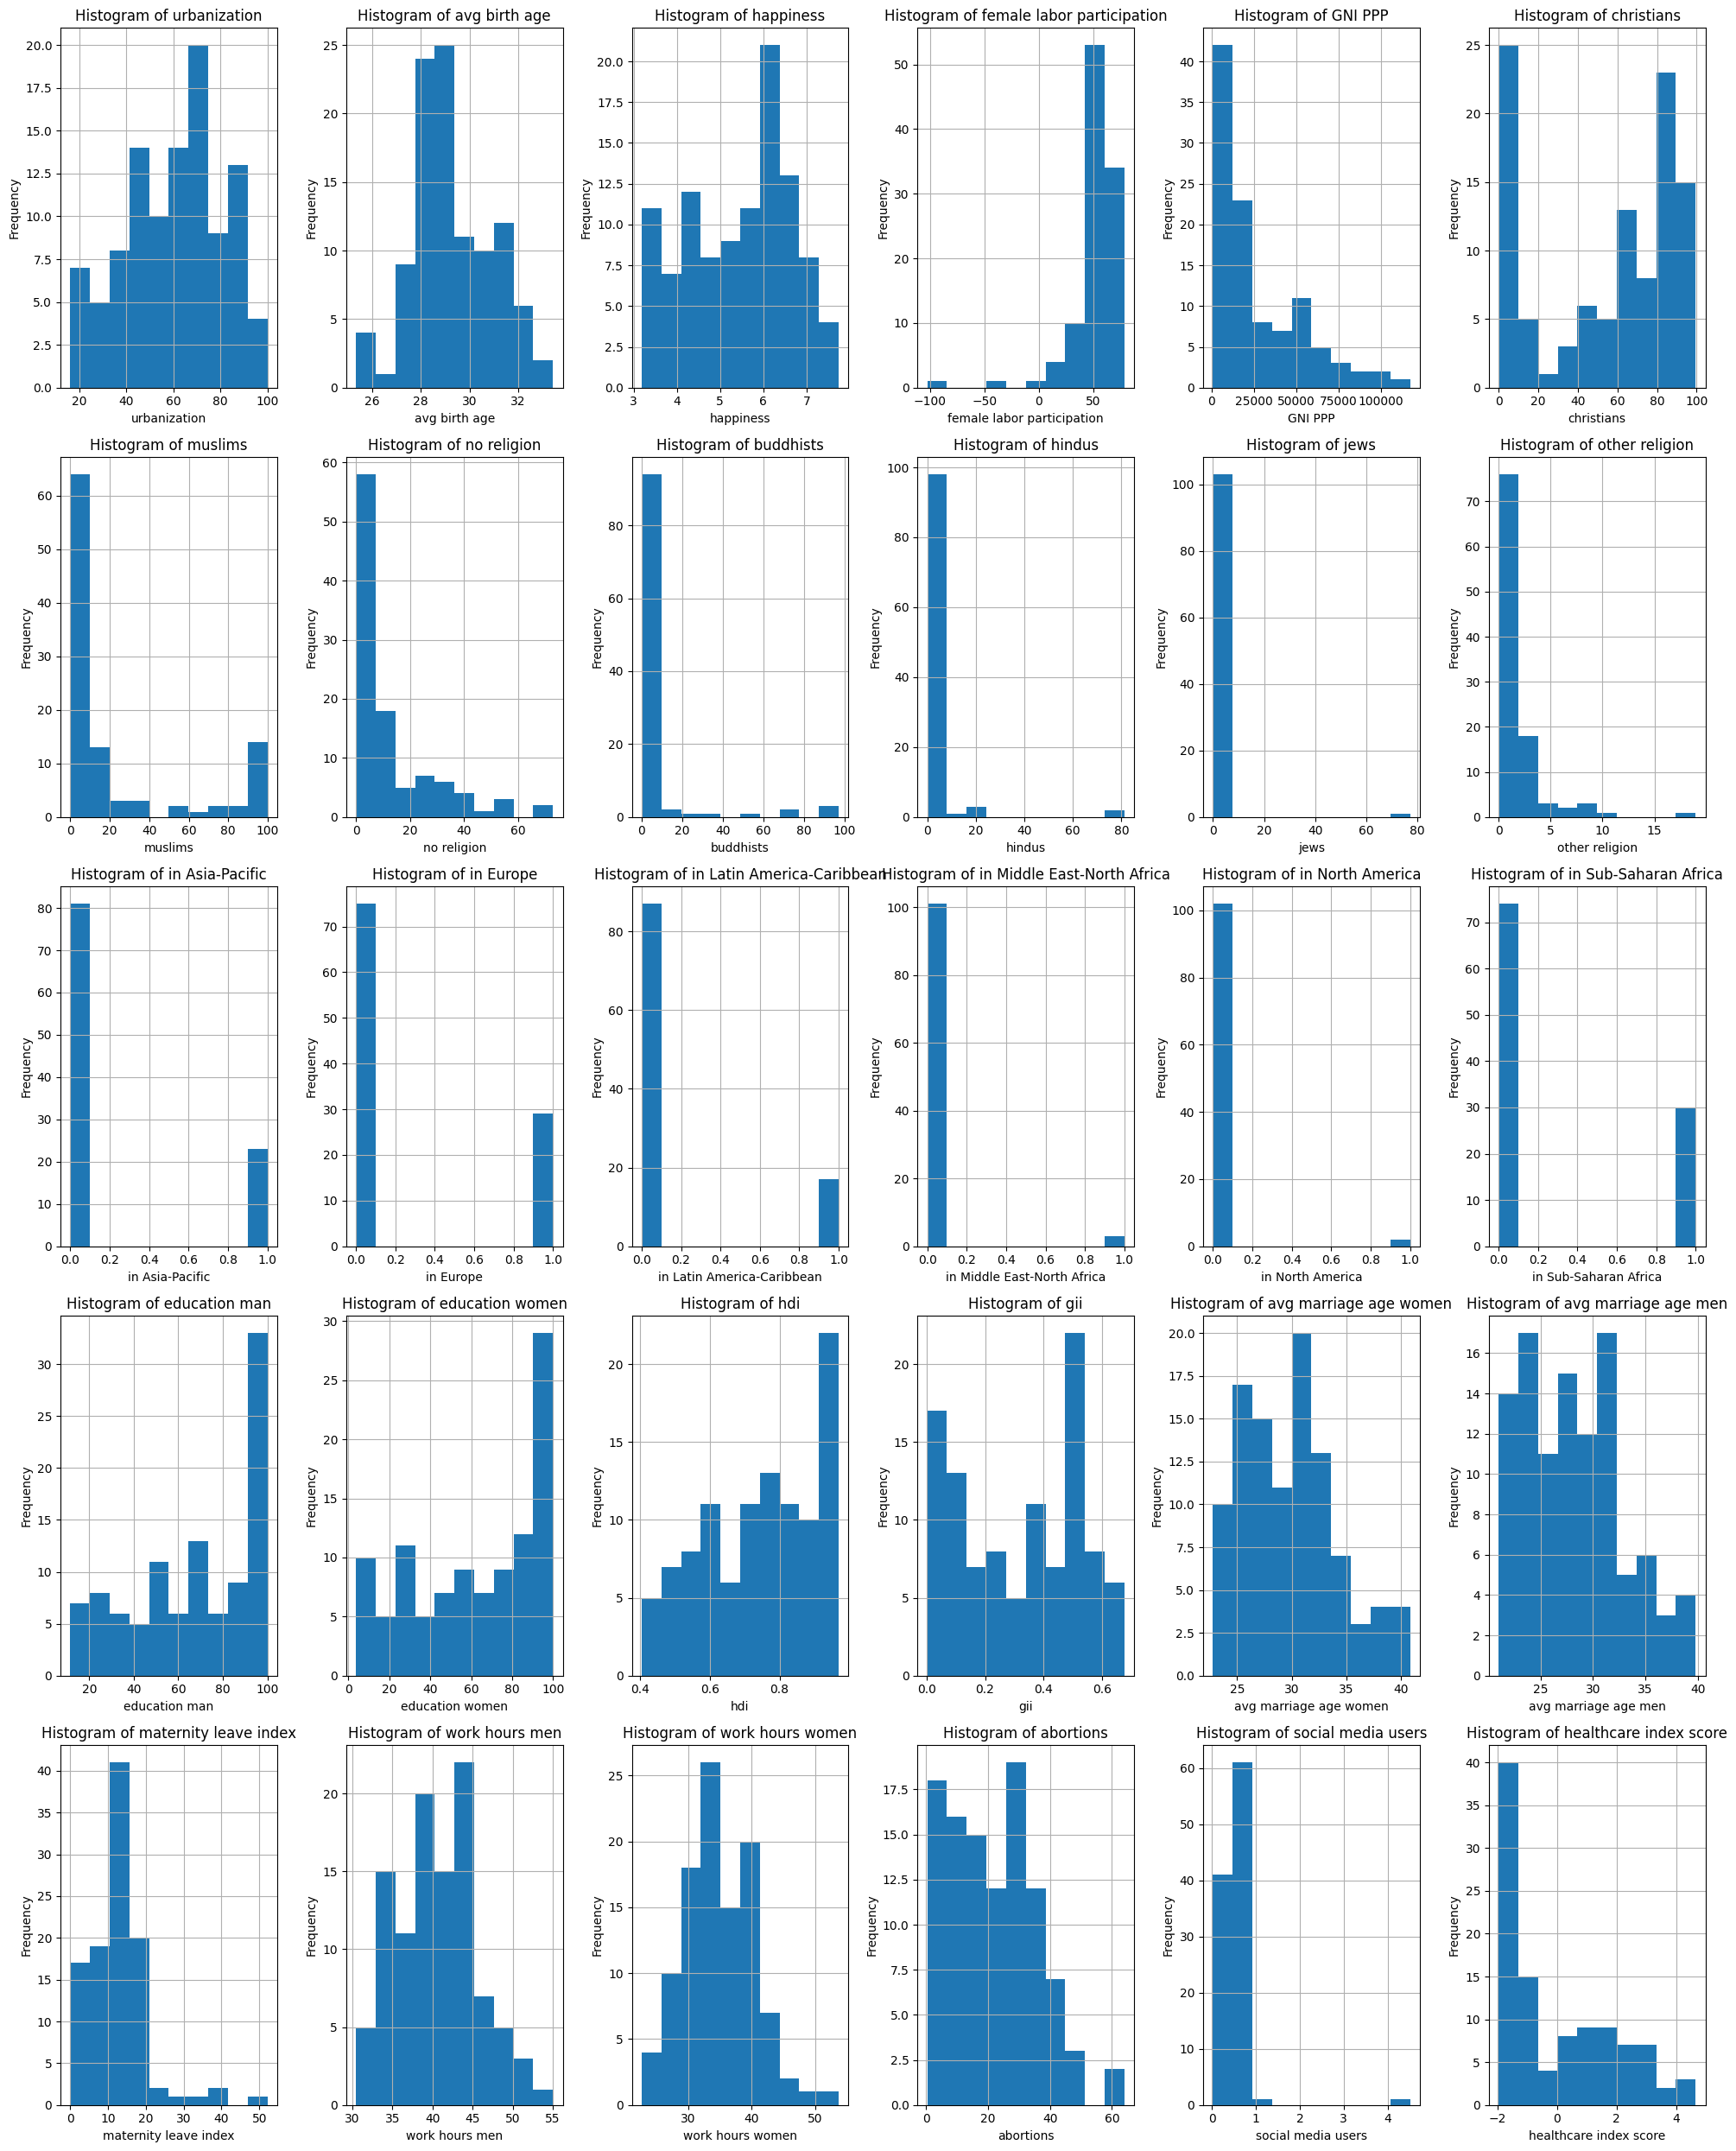

In [21]:
import matplotlib.pyplot as plt
import math

# Get the list of columns
columns = X_train.columns

# Calculate the number of rows needed
n_cols = 6
n_rows = math.ceil(len(columns) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Plot histograms for all features
for i, column in enumerate(columns):
    axes[i].hist(X_train[column], bins=10)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
def lasso_scaling_2023(X_train,X_test):
  log_transform = [
      'GNI PPP','no religion','other religion','hindus','jews','buddhists']

In [3]:
data=init_process()

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

In [10]:
newdata=calc_features_year(data,2023)

In [19]:
find_missing_features(newdata[0])

Countries with NaN values in their features:
['Afghanistan', 'Albania', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Barbados', 'Bermuda', 'Bhutan', 'Bosnia and Herzegovina', 'British Virgin Islands', 'Brunei Darussalam', 'Cabo Verde', 'Cayman Islands', 'Central African Republic', 'Channel Islands', 'Congo, Rep.', 'Cuba', 'Curacao', 'Cyprus', 'Dominica', 'Dominican Republic', 'Equatorial Guinea', 'Eritrea', 'Faroe Islands', 'Fiji', 'French Polynesia', 'Georgia', 'Gibraltar', 'Greenland', 'Grenada', 'Guam', 'Guinea-Bissau', 'Guyana', 'Hong Kong SAR, China', 'Iraq', 'Ireland', 'Isle of Man', 'Jordan', 'Kazakhstan', 'Kiribati', "Korea, Dem. People's Rep.", 'Kosovo', 'Kuwait', 'Kyrgyz Republic', 'Lebanon', 'Liberia', 'Libya', 'Liechtenstein', 'Macao SAR, China', 'Malawi', 'Malaysia', 'Maldives', 'Malta', 'Marshall Islands', 'Mauritius', 'Micronesia, Fed. Sts.', 'Moldova', 'Monaco', 'Montenegro', 'Morocco', 'Naur

In [14]:
import pandas as pd

pd.set_option('display.max_rows', None)

df_features = newdata[0]
display(df_features['female labor participation'])

# You can reset the option later if needed
# pd.reset_option('display.max_rows')

Afghanistan                        5.155
Albania                           53.207
Algeria                           14.132
American Samoa                       NaN
Andorra                              NaN
Angola                            73.224
Antigua and Barbuda                  NaN
Argentina                         52.957
Armenia                           56.786
Aruba                                NaN
Australia                         62.374
Austria                           55.812
Azerbaijan                        60.952
Bahamas, The                      66.733
Bahrain                           43.096
Bangladesh                        43.712
Barbados                          60.124
Belarus                           57.385
Belgium                           49.831
Belize                            49.182
Benin                             74.183
Bermuda                              NaN
Bhutan                            56.619
Bolivia                           71.909
Bosnia and Herzegovina            39.533
Botswana                          63.426
Brazil                            53.205
British Virgin Islands               NaN
Brunei Darussalam                 53.527
Bulgaria                          51.043
Burkina Faso                      41.294
Burundi                           80.138
Cabo Verde                        50.419
Cambodia                          73.986
Cameroon                          57.148
Canada                            61.134
Cayman Islands                       NaN
Central African Republic          65.845
Chad                              48.702
Channel Islands                   50.687
Chile                             51.963
China                             59.948
Colombia                          51.859
Comoros                           41.143
Congo, Dem. Rep.                  62.309
Congo, Rep.                       66.341
Costa Rica                        44.088
Cote d'Ivoire                     58.864
Croatia                           47.144
Cuba                              39.947
Curacao                              NaN
Cyprus                            62.475
Czechia                           53.235
Denmark                           59.812
Djibouti                          18.669
Dominica                             NaN
Dominican Republic                52.482
Ecuador                           52.521
Egypt, Arab Rep.                    15.3
El Salvador                       46.622
Equatorial Guinea                 52.997
Eritrea                           72.385
Estonia                           61.049
Eswatini                          44.886
Ethiopia                          57.378
Faroe Islands                        NaN
Fiji                              38.593
Finland                           57.489
France                            51.826
French Polynesia                  46.295
Gabon                             41.863
Gambia, The                       45.242
Georgia                           55.037
Germany                           55.848
Ghana                             61.815
Gibraltar                            NaN
Greece                            44.673
Greenland                            NaN
Grenada                              NaN
Guam                              56.425
Guatemala                         40.412
Guinea                            42.094
Guinea-Bissau                     56.485
Guyana                            40.327
Haiti                             60.128
Honduras                          39.675
Hong Kong SAR, China              52.412
Hungary                           53.938
Iceland                           70.368
India                             31.243
Indonesia                         52.545
Iran, Islamic Rep.                13.592
Iraq                              10.872
Ireland                           59.968
Isle of Man                          NaN
Israel                            61.825
Italy                             41.313
Jamaica                

In [10]:
print(data)

{('Aruba', 1960): (4.567, [np.float64(46.08659), np.float64(29.484), nan, np.float64(25.73), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), ('Aruba', 1961): (4.422, [np.float64(46.004547), np.float64(29.354), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), ('Aruba', 1962): (4.262, [np.float64(46.26234), np.float64(29.224), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), ('Aruba', 1963): (4.107, [np.float64(46.728985), np.float64(29.093), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,